In [116]:
from IPython.display import display, HTML
display(HTML('''<img src="https://www.fhnw.ch/de/medien/logos/media/fhnw_ht_e_10mm.jpg">'''))

## NLP Mathematik Challenge Track Sprint 4

In [1]:
# ignore warings
import warnings
warnings.simplefilter("ignore")

In [2]:
!pip install wikipedia

  Stored in directory: /Users/Nicole/Library/Caches/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia


In [67]:
import pandas as pd
import numpy as np
from scipy import stats
import sys
import nltk
import math
import itertools
from scipy.stats import normaltest
from scipy.stats import ks_2samp
import re
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
from scipy import stats
from statsmodels.stats import weightstats as stests

### Import of the necessary functions of the model from NLP Assigment_01

In [68]:
#from Assignment_1_nicole_koenigstein import language_tree,mean_de,mean_en

In [69]:
people_en = pd.read_csv('people_wiki_EN.csv', sep=',')
people_de = pd.read_csv('10k-people-raw.csv', sep=';')

In [70]:
def character_distribution(people):
    # Implementieren Sie eine Funktion die die Buchstabenhäufigkeiten berechnet.
    # Die Funktion soll folgendes zurückgeben:
    #  mean: Durchschnittlicher relative Häufigkeit pro Buchstabe 
    #  std: Relative Standardabweichung pro Buchstabe
    #  dist: Relative Häufigkeit pro Text und pro Buchstabe 
    mean = np.zeros(shape = 26)
    std = np.zeros(shape = 26)
    dist = np.zeros(shape = (len(people), 26))
    
    def get_chars():
        return {chr(c):0 for c in range(ord('a'), ord('z')+1)}
    def get_freq(text):
        chars = get_chars()
        for i in text: 
            if i in chars: 
                chars[i] += 1
        return list(chars.values())
    
    freq = people.apply(get_freq)
    mean = np.mean(list(freq), axis=0)
    std = np.std(list(freq), axis=0)
    dist = freq.apply(lambda x: mean/x)
    dist = np.array(list(dist))
    
    return mean, std, dist

In [71]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini

# Select the best split point for a dataset
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

# Build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

# Print a decision tree
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        #print_tree(node['left'], depth+1)
        #print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))
    
    return node['value']

In [72]:
# Build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

# Print a decision tree
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        #print_tree(node['left'], depth+1)
        #print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))
    
    return node['value']

"""dataset = [[2.771244718,1.784783929,0],
    [1.728571309,1.169761413,0],
    [3.678319846,2.81281357,0],
    [3.961043357,2.61995032,0],
    [2.999208922,2.209014212,0],
    [7.497545867,3.162953546,1],
    [9.00220326,3.339047188,1],
    [7.444542326,0.476683375,1],
    [10.12493903,3.234550982,1],
    [6.642287351,3.319983761,1]]"""

#mean_de, std_de, dist_de = character_distribution(people_de['text'])
#mean_en, std_en, dist_en = character_distribution(people_en['text'])

# Change N to the number of rows that you want to take while training. Can be increased if more computation power
N = 20
dist_de = np.c_[dist_de[:N], np.zeros(N)]
dist_en = np.c_[dist_en[:N], np.ones(N)]

#Build data for Decision tree
dataset = np.r_[ dist_de, dist_en]

tree = build_tree(dataset, 1, 1)
tree_value = print_tree(tree)

# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

#  predict with a stump


def language_tree(mean_de, mean_en, texts):
  
    _, _, dist_test = character_distribution(texts)

    lang = []
    #set the stump['value'] to value printed from tree
    stump = {'index': 0, 'right': 1, 'value': tree_value, 'left': 0}
    for row in dist_test:
        prediction = predict(stump, row)
        if prediction == 0:
            lang.append('G')
        else:
            lang.append('E')
        
    """for i in range(texts.shape[0]):

        random_value = np.random.rand()
        if random_value < 0.4:
            lang.append('E')
        elif random_value < 0.8:
            lang.append('G')
        else:
            lang.append('X')"""
   
    return lang

[X1 < 0.535]


### Get the mean


In [136]:
my_mean_de, my_std_de, my_dist_de = character_distribution(people_de['text'])
my_mean_en, my_std_en, my_dist_en = character_distribution(people_en['text'])
my_mean_de

array([ 361.4953,  100.5209,  159.6028,  271.9414, 1002.7192,   88.0962,
        153.4842,  243.6621,  504.0223,    7.2164,   67.0105,  229.9066,
        153.6124,  594.2286,  189.2482,   47.7287,    1.2004,  501.2697,
        354.5763,  371.8899,  237.1428,   49.2719,   71.212 ,    4.0782,
         15.4584,   66.0362])

### Import the necessary funtions from Model_KP

In [74]:
#language_treemod = lambda text: language_tree(mean_de, mean_en, text)

In [75]:
#from Model_KP import determine_language,mean_de,mean_en,std_en,std_de

In [76]:
def theircharacter_distribution(people):
    # Implementieren Sie eine Funktion die die Buchstabenhäufigkeiten berechnet.
    # Die Funktion soll folgendes zurückgeben:
    #  mean: Durchschnittlicher relative Häufigkeit pro Buchstabe 
    #  std: Relative Standardabweichung pro Buchstabe
    #  dist: Relative Häufigkeit pro Text und pro Buchstabe 
    mean = np.ones(shape = 26)
    std = np.ones(shape = 26)
    dist = np.ones(shape = (len(people), 26))
    
    hist = np.ones(shape = (26,len(people)))
    
    
    # TODO
    N = len(people)
    letters = 'abcdefghijklmnopqrstuvwxyz'
    for i in range(N):
        lenPeople = len(re.sub(r"[^A-Za-z]+",'',people[i]))
        if (lenPeople > 0):
            fdist = nltk.FreqDist(char.lower() for char in people[i] if char in letters)
            for idx, letter in enumerate(letters):
                percent = np.divide(fdist[letter],lenPeople)
                dist[i,idx] = percent
                hist[idx,i] = percent
            pass
        pass
    for idx, letter in enumerate(letters):
        mean[idx] = np.mean(hist[idx])
        std[idx] = np.std(hist[idx])          
    
    
    return mean, std, dist

In [77]:
def determine_language(mean_de, std_de, mean_en, std_en, texts):
    # Implementieren Sie eine Funktion zur Erkennung der Sprache
    lang = []
    
    for i in range(texts.shape[0]):
        isGerman = 0
        isEnglish = 0
        isOther = 0.26 #fixedAccuracy (1% per letter)
        removeAccuracyDe = 1
        removeAccuracyEn = 1
        #print(texts[i])
        mean_text = distribution_text(texts[i])
        for k, let in enumerate(mean_de):
            if (mean_text[k]==0):
                removeAccuracyDe -= mean_de[k]
                removeAccuracyEn -= mean_en[k]
        pass
        for j,letter in enumerate(mean_de):
            if (mean_text[j]>0):
                #for elimination of negative value
                isGerman += np.sqrt(np.square(mean_text[j]-(mean_de[j]/removeAccuracyDe)))
                
                isEnglish += np.sqrt(np.square(mean_text[j]-(mean_en[j]/removeAccuracyEn)))
            #else:
                #Remove 1 percent if text doesn't contain the letter
                #isOther -= 0.01
        pass
        if isGerman < isEnglish and isGerman < isOther:
            lang.append('G')
        elif isEnglish < isGerman and isEnglish < isOther:
            lang.append('E')
        else:
            lang.append('X')
            
    return lang

In [78]:
def distribution_text(text):
    mean = np.ones(shape = 26)
    letters = 'abcdefghijklmnopqrstuvwxyz'
    lenText = len(re.sub(r"[^A-Za-z]+",'',text))
    if (lenText> 0):
        fdist = nltk.FreqDist(char.lower() for char in text if char in letters)
        for idx, letter in enumerate(letters):
            percent = np.divide(fdist[letter],lenText)
            mean[idx] = percent
        pass
    pass
    return mean




In [135]:
their_mean_de, their_std_de, their_dist_de = theircharacter_distribution(people_de['text'])
their_mean_en, their_std_en, their_dist_en = theircharacter_distribution(people_en['text'])
their_mean_de.shape

(26,)

In [80]:
#determine_languagemod = lambda text: determine_language(mean_de, std_de, mean_en, std_en,text)

In [81]:
# ignore warings
import warnings
warnings.simplefilter("ignore")

In [102]:
# create a dictionary of the wikipedia articles to be collected
wikipedia_articles = {'language':[],'text':[]}
# list of search terms to be searched

# search_terms = ["New York","Berlin"] # "Dortmund","Los Angeles","Barack Obama","Angela Merkel","Bill Gates","Steve Jobs","London"
# loop in each language, set wikipedia lang and look for the results, appending to the dictionary of wikipedia articles
for language in ["de","en","pt","fr","pam","bs","it","sv"]:
    print('Language = '+ language)
    wikipedia.set_lang(language)
    for i in [10]*50:
        search_terms = wikipedia.random(pages=10)
        for search_term in search_terms:
            print('Search_term = ' + search_term)
            if 'disambiguation' in search_term:
                print(search_term)
            try:
                p = wikipedia.summary(search_term,sentences = 10,auto_suggest=False, redirect=True)
            except wikipedia.exceptions.DisambiguationError as e_1:
                print(e_1.options)
            
            except wikipedia.exceptions.PageError as e_2:
                print (e_2.args)
                print (e_2.paeid)
                print (e_2.message)
                
                s = random.choice(e_1.options)
                #suggestion = wikipedia.suggest(s)
                p = wikipedia.summary(s,sentences = 10,auto_suggest=False, redirect=True)
        
            wikipedia_articles['text'].append(p)
            wikipedia_articles['language'].append(language)

Language = de
Search_term = Bellmer
['Hans Bellmer', 'Herbert Bellmer', 'Margarete Bellmer']
Search_term = Durcheinander (Tschechow)
Search_term = Alexei Lwowitsch Efros
Search_term = Burgstall Einberg
Search_term = Emil von Burchard
Search_term = N-Trak
Search_term = Rockville Historic District
['Rockville Historic District (Connecticut)', 'Rockville Historic District (Indiana)', 'Rockville Historic District (South Carolina)']
Search_term = Anna Maria zu Solms-Sonnenwalde
Search_term = Herbert Hinterleithner
Search_term = Quasispitzenwert
Search_term = Windpark Fleschenbach-Neustall
Search_term = Anna Brassey
Search_term = CNNA HL-6
Search_term = Hama Amadou
Search_term = Prochladnoje
['Oblast Kaliningrad', 'Prochladnoje (Kaliningrad, Selenogradsk)', 'Prochladnoje (Kaliningrad, Slawsk)', 'Prochladnoje (Primorje)', 'Prochladnoje (Smolensk)', 'Prochladnaja', 'Prochladny']
Search_term = Nekrolog 1593
Search_term = D-Irie
Search_term = Marajo
['Marajó', 'Johnny Marajo']
Search_term = Roch

Search_term = Gasometer Wienerberg
Search_term = Diözese Masuren
Search_term = Nexon
Search_term = Juantxo Elía Vallejo
Search_term = Johann Bartels
['Johann August Bartels', 'Johann Christian Martin Bartels', 'Johann Heinrich Bartels', 'Johann Wilhelm Bartels']
Search_term = Johann Wilhelm Baier (Theologe)
Search_term = Ohrloser Graslanddrache
Search_term = Geisei-Observatorium
Search_term = Haus zum Lindenbaum
Search_term = Haverlandt
Search_term = FernGully – Christa und Zaks Abenteuer im Regenwald
Search_term = Flugabwehrraketenkommando 4
Search_term = Franz Berg
['Franz Berg (Theologe)', 'Franz von Berg', 'Franz Berg (Maler)', 'Franz Daniel Berg', 'Franz-Josef Berg']
Search_term = Konstruktvalidität
Search_term = Trélou-sur-Marne
Search_term = Pangasius djambal
Search_term = Kanton Saint-Mandé
Search_term = Paolo Paruta
Search_term = Foucault und Recht
Search_term = Bundestagswahl 1994
Search_term = Anna Herrmann
Search_term = Liste der Stolpersteine im Kölner Stadtteil Junkersdor

['Aubachquelle (Menchau)', 'Aubachquelle (Wiesen)']
Search_term = Liste der Staatsoberhäupter 926
Search_term = Bierbach (Begriffsklärung)
['Bierbach', 'Bierbach (Odenwald)', 'Bierbach (Amdorfbach)', 'Bierbach (Gersprenz)', 'Bierbach (Kailbach)', 'Bierbach (Kondeler Bach)', 'Bierbach (Prüm)', 'Bierbach (Rednitz)', 'Bierbach (Wannebach)', 'Johannes Bierbach', 'Martin Bierbach', 'Biergraben']
Search_term = Leon Sametini
Search_term = Élysette
Search_term = Carl Allen
Search_term = Mark Jakowlewitsch Asbel
Search_term = St. Wendelin (Brandenberg)
Search_term = Jurk!
Search_term = Dan Wall
Search_term = Dürnrohr
['Dürnrohr (Gemeinde Zwentendorf)', 'Kraftwerk Dürnrohr', 'GK Dürnrohr', 'Umspannwerk Dürnrohr', 'Müllverbrennungsanlage Dürnrohr']
Search_term = Unterabteilung
Search_term = Tiruvallur (Distrikt)
Search_term = Brüderliche Zusammenarbeit der Kriegsgefangenen
Search_term = NBA All-Star Weekend Skills Challenge
Search_term = Illhaeusern
Search_term = Gisela Fox-Düvell
Search_term = N

Search_term = Katie Findlay
Search_term = Österreichische Gesellschaft für Erdölwissenschaften
Search_term = Fredrik Berglund
Search_term = Slice the Cake
Search_term = Julia Kleiter
Search_term = CAWR
['Center for Advanced Water Research', 'Castell Cawr', 'Cavares']
Search_term = Wilhelm Alexander von Dohna-Schlodien
Search_term = Almersberg (Pfalz)
Search_term = Brünnleingraben
['Brünnleingraben (Balbach)', 'Brünnleingraben (Weihergraben)', 'Hinteres Brünnlein', 'Brünnle']
Search_term = Cissusblättriger Ahorn
Search_term = Carl Ludwig Deffner
Search_term = Podbi-Park
Search_term = Bick
['Andreas Bick', 'Eduard Bick', 'Erich Wolfgang Bick', 'Felix Bick', 'George Herman Bick', 'Hans Haller (Textdichter)', 'Jamie Bick', 'Josef Bick', 'Juanda Bick', 'Karl Bick (Politiker, 1871)', 'Karl Bick (Politiker, 1896)', 'Martina Bick', 'Patrick Bick', 'Rolf Bick', 'Sam Bick', 'Stewart Bick', 'Wilhelm Bick', 'BIK', 'BIC', 'BIG']
Search_term = Duesenberg
Search_term = Rock am See
Search_term = Aaron

Search_term = Edward Seymour, 8th Duke of Somerset
Search_term = 1869
Search_term = Neferhotep I
Search_term = 1925 Tour de France, Stage 10 to Stage 18
Search_term = Afilias
Search_term = Invitee
Search_term = May & Baker
Search_term = Palmira, Cuba
Search_term = Nelli Neumann
Search_term = The Marked Men
Search_term = 2017–18 Saint Louis Billikens women's basketball team
Search_term = Western Zonal Council
Search_term = Parthenina multicostata
Search_term = Howard Balloch
Search_term = Autant en emporte le vent
Search_term = Horizon (Eddie Rabbitt album)
Search_term = Sixth power
Search_term = Snug Cove
Search_term = David McTaggart
Search_term = Samuel D. Jackson
Search_term = Stephen G. Emerson
Search_term = Eleanor of England, Queen of Castile
Search_term = Erigeron parryi
Search_term = Hot Springs (band)
Search_term = Czech goose
Search_term = Union Township, Jackson County, Iowa
Search_term = Honduran fruit-eating bat
Search_term = Swannington railway station
Search_term = Battl

Search_term = Giant otter shrew
Search_term = Rządza (river)
Search_term = 60th New York Volunteer Infantry
Search_term = Marie (given name)
Search_term = Ray Aguilar
Search_term = Rebecca Kleefisch
Search_term = Julius Curtis
Search_term = SF3B1
Search_term = Old Jewish Cemetery, Cincinnati
Search_term = Louisa Lippmann
Search_term = The Jack Kerouac Writers in Residence Project of Orlando, Inc.
Search_term = Funky Turns 40
Search_term = Deersville Historic District
Search_term = Gozalabad
Search_term = 1946 European Athletics Championships – Women's 100 metres
Search_term = Phagemid
Search_term = Barend Christiaan van Calker
Search_term = Thomas Hache
Search_term = Kawaimina languages
Search_term = Lux Mundi (statue)
Search_term = Stephanie Rothenberg
Search_term = Giovanni Bozzi
Search_term = It's On (Dr. Dre) 187um Killa
Search_term = Tougeki – Super Battle Opera
Search_term = Antti
Search_term = HLA B7-DR15-DQ6
Search_term = Linos Chrysikopoulos
Search_term = Seize the Day
['Newsi

Search_term = Lista de distritos da Libéria
Search_term = Sampaio (Tocantins)
Search_term = Mark Madsen
Search_term = Pseudohynobius flavomaculatus
Search_term = Pinaça
Search_term = Pewamo
Search_term = Michael Feldman
Search_term = Medalha da Paz Otto Hahn
Search_term = Alberi José Ferreira de Matos
Search_term = A Virgem amamentando o Menino e São João Batista criança em adoração
Search_term = Death and All His Friends
Search_term = Lista de aeroportos da Colômbia
Search_term = Luteranismo na Letônia
Search_term = Merrey-sur-Arce
Search_term = Especialista de carga (NASA)
Search_term = Supla (álbum)
Search_term = Galateia
Search_term = Maria Luisa Vicuña
Search_term = Open Game License
Search_term = (36201) 1999 TE98
Search_term = Emirates Stadium
Search_term = Feito o Amanhecer
Search_term = Church of Realities
Search_term = Pacific Overtures (musical)
Search_term = Giselle Kañevsky
Search_term = Robert Hill
Search_term = Federação Kosovar de Voleibol
Search_term = Adonias Fonseca


Search_term = Alexandra de Luxemburgo
Search_term = Psicologia existencial
Search_term = Údolí včel
Search_term = Heart of Stone Tour
Search_term = Talos (Dungeons & Dragons)
Search_term = Hangman's Knot
Search_term = Noel Clarke
Search_term = Breathe In. Breathe Out.
Search_term = Sonorella eremita
Search_term = Condado de Wood (Ohio)
Search_term = USS George H. W. Bush (CVN-77)
Search_term = Vila Autódromo
Search_term = Andrzej Sekuła
Search_term = Hylophorbus proekes
Search_term = Inconfidência Mineira (filme)
Search_term = Editorial Salvat
Search_term = Rio Sarapuí
Search_term = Lidiane Shayuri
Search_term = Jonas Stampe
Search_term = Marlene Dietrich
Search_term = Nathan Stewart-Jarrett
Search_term = Magali Messmer
Search_term = Zvezdan
Search_term = Rocky Hill
Search_term = Kurenai
Search_term = IHF Super Globe
Search_term = (39557) Gielgud
Search_term = Campeonato Sul-Americano de Corta-Mato de 1993
Search_term = Abarema callejasii
Search_term = Termos da oração
Search_term = Dr

Search_term = Campeonato Paraguaio de Futebol de 1998
Search_term = Eusko Abendaren Ereserkia
Search_term = Wyatt Russell
Search_term = Shinobi (série)
Search_term = Young Artist Awards 2010
Search_term = Daphnella mazatlanica
Search_term = Melado de cana
Search_term = Banda Zil
Search_term = NGC 2775
Search_term = Praia da Aldeia do Coco
Search_term = August Conradi
Search_term = Torgny Lindgren
Search_term = Florencia (Cauca)
Language = fr
Search_term = Pholcus wangxidong
Search_term = Samuel Raapoto
Search_term = Ōta Masamitsu
Search_term = Antonio Vico
Search_term = Kenta Yumiya
Search_term = Hallerndorf
Search_term = Myslinka
Search_term = Quatuor à cordes no 12 de Dvořák
Search_term = Hoodoo Mountain
Search_term = Escadron
Search_term = Marthe (film)
Search_term = Lac de Pilate
Search_term = Sainte-Croix-Grand-Tonne
Search_term = Manuel Lima
Search_term = Charles Ricketts
Search_term = HACEK
Search_term = Ligue majeure
Search_term = Teutamus calceolatus
Search_term = Alessio Chio

Search_term = Total Khéops
Search_term = Boungou-Folgou
Search_term = Zweite Oberliga Ouest (1949-1963) 1958-1959
Search_term = (12647) Pauluspotter
Search_term = La Conjecture de Fermat
Search_term = L'Italienne
Search_term = Gaston-Pierre de Lévis-Mirepoix
Search_term = Pintade à poitrine blanche
Search_term = Interrégionaux Centre-Est de cross-country
Search_term = Melanie Martinez
Search_term = Royaume d'Égypte
Search_term = Antonina Koshel
Search_term = Marie Pavie
Search_term = Francesco Caetani
Search_term = Plage de Pointe Marin
Search_term = Liste des navires de l'United States Navy : W-Z
Search_term = Curtiss CR
Search_term = Saint-Étienne-de-Cuines
Search_term = Spermophora
Search_term = Tournoi de tennis de Monterrey (WTA 2009)
Search_term = André Vervoort
Search_term = Perki
Search_term = Daisen-ji
Search_term = Bahrani
Search_term = Fief de Viipuri
Search_term = James Wharton
Search_term = Saison 2016-2017 des Hornets de Charlotte
Search_term = Palais Liévano
Search_term 

Search_term = Alimentation
Search_term = Tiphaine
Search_term = Microrégion de Joaçaba
Search_term = Bouan (Bondokuy)
Search_term = Hockliffe
Search_term = Championnats de France de ski nordique 2014
Search_term = Jean-Samuel Curtet
Search_term = Antti Muurinen
Search_term = Urodacus mckenziei
Search_term = Finolhu (Alif Dhaal)
Search_term = Tow Ubukata
Search_term = Desportiva Ferroviária
Search_term = Demonic (album)
Search_term = Boulevard Viau
Search_term = Jack McKenzie (hockey sur glace)
Search_term = Six Jours d'Ottawa
Search_term = Bachelor of Civil Law
Search_term = Alain Belda
Search_term = Château des Gouttes
Search_term = Goudaouta
Search_term = Métopimazine
Search_term = José Luis Perales
Search_term = Gare de Shukugawa
Search_term = XXXVe congrès du Parti communiste français
Search_term = Andrea Martin
['Andrea Martin', 'Andrea Martin']
Search_term = Urones de Castroponce
Search_term = Sambre (homonymie)
['Sambre', 'Sambre', '(4016) Sambre', 'Sambre-et-Meuse']
Search_term

Search_term = Lormont
Search_term = Saharanpur
Search_term = Tala da reng balen ning Albacete
Search_term = Capiz
Search_term = Cologne
Search_term = Amanung Isinay
Search_term = Kaarian ning Holanda
Search_term = Tukal
Search_term = Ding Commune ning Côtes-d'Armor a departamentu
Search_term = Barjac, Gard
Search_term = Camargo, Cantabria
Search_term = Lugus, Sulu
Search_term = Loir-et-Cher
Search_term = Datu Anggal Midtimbang, Maguindanao
Search_term = Avèze, Gard
Search_term = Aguman da reng Bangsa king Mauli Aslagang Asia
Search_term = Eneru 25
Search_term = King Musa ning Taguimpan Ku
Search_term = Robert Clive
Search_term = Mambusao, Capiz
Search_term = Bac Kan Lalawigan
Search_term = Vandavasi
Search_term = Pililla, Rizal
Search_term = Eneru 18
Search_term = Nobiembri 17
Search_term = Gigaquit, Surigao del Norte
Search_term = Francisco Hidalgo y Caballero
Search_term = Columbia, South Carolina
Search_term = Hüttlingen, Germany
Search_term = Nelson Mandela
Search_term = Bulati
Sea

Search_term = Tirupati
Search_term = Ataki keng pusu
Search_term = Pandharpur
Search_term = Amanung Sebop
Search_term = Steven Spielberg
Search_term = Liv and Maddie
Search_term = Benguet
Search_term = Ding Comuni ning Lalawigan ning Pesaro e Urbino
Search_term = Ipas
Search_term = Villaba, Leyte
Search_term = Alturas, California
Search_term = Papa Piu VIII
Search_term = Binidayan, Lanao del Sur
Search_term = La Cavalerie
Search_term = Southern Leyte State University
Search_term = Burgos, Ilocos Sur
Search_term = Carnota
Search_term = 1965
Search_term = 2024
Search_term = Piddig, Ilocos Norte
Search_term = Alfoz de Quintanadueñas
Search_term = Tamparan, Lanao del Sur
Search_term = Cranberry
Search_term = Tala da reng tungku (kabisera) ning United States
Search_term = Zamboanga del Norte
Search_term = Tanglao, Aida, D.
Search_term = Ahmadnagar
Search_term = Belmont, Bas-Rhin
Search_term = Juniu 3
Search_term = Papa Piu XII
Search_term = Guanajuato
Search_term = Siocon, Zamboanga del Nor

Search_term = Grb Istočnog Timora
Search_term = IC 75
Search_term = Deepdale
Search_term = Stancija Vodopija
Search_term = Koče (Kočevje)
Search_term = Kebelj
Search_term = Podlug (Sanski Most)
Search_term = Eneida
Search_term = Ugrožena vrsta
Search_term = NGC 6664
Search_term = IC 4607
['IC 4607-1', 'IC 4607-2', 'Novi opći katalog', 'Spisak IC objekata', 'Spisak NGC objekata', 'p', 'r', 'u', '←', 'IC 4501', 'IC 4502', 'IC 4503', 'IC 4504', 'IC 4505', 'IC 4506', 'IC 4507', 'IC 4508-1', 'IC 4508-2', 'IC 4509', 'IC 4510', 'IC 4511', 'IC 4512', 'IC 4513', 'IC 4514', 'IC 4515', 'IC 4516', 'IC 4517', 'IC 4518', 'IC 4518A', 'IC 4518B', 'IC 4519', 'IC 4520', 'IC 4521', 'IC 4522', 'IC 4523', 'IC 4524', 'IC 4525', 'IC 4526', 'IC 4527', 'IC 4528', 'IC 4529', 'IC 4530', 'IC 4531', 'IC 4532', 'IC 4533', 'IC 4534', 'IC 4535', 'IC 4536', 'IC 4537', 'IC 4538', 'IC 4539', 'IC 4540', 'IC 4541', 'IC 4542', 'IC 4542A', 'IC 4542B', 'IC 4543', 'IC 4544', 'IC 4545', 'IC 4546', 'IC 4547', 'IC 4548', 'IC 454

Search_term = Novovjekovna filozofija
Search_term = Snukerska sezona 1997/1998.
Search_term = McLaren
Search_term = Zoë Heller
Search_term = Ivaniš Vlatković
Search_term = In God We Trust
Search_term = Cirkonij
Search_term = Salakovci
Search_term = Svante August Arrhenius
Search_term = Evropsko prvenstvo u nogometu za žene 1991.
Search_term = NGC 4015-1
Search_term = Veliki Budići
Search_term = Trviž
Search_term = NGC 5502
Search_term = Eddie Baily
Search_term = M60 BST
Search_term = Hlor
Search_term = PC kartica
Search_term = Adam Smith
Search_term = Roženica
Search_term = IC 5229
Search_term = Rigelj
['Rigelj pri Ortneku', 'Mali Rigelj', 'Veliki Rigelj']
Search_term = Sunčeva zvijezda
Search_term = IC 78
Search_term = IC 2962
Search_term = Fosfotransferaza
Search_term = Banovci (Bebrina)
Search_term = NGC 294
Search_term = Orijevac
Search_term = Malajski jezik
Search_term = Rodine pri Trebnjem
Search_term = Kozara (film)
Search_term = Mustafa Peštalić
Search_term = 489.
Search_term =

Search_term = Trnovski Vrh
Search_term = Slavčo Koviloski
Search_term = Malo Polje (Mostar)
Search_term = IC 5064
Search_term = Tinsko
['Spodnje Tinsko', 'Zgornje Tinsko']
Search_term = Mošenik
['Mošenik (Moravče)', 'Mošenik (Zagorje ob Savi)']
Search_term = NGC 826-1
Search_term = NGC 4380
Search_term = Ole Rømer
Search_term = NGC 1798
Search_term = Merovinzi
Search_term = Čajničko jevanđelje
Search_term = New Orleans Pelicans
Search_term = Ferrari F2004
Search_term = Stjepan Tomaš, kralj Bosne
Search_term = NGC 3060
Search_term = NGC 5447
Search_term = IC 4809
Search_term = Smallville (sezona 1)
Search_term = Rezultati nogometne reprezentacije Kipra u kvalifikacijama za Evropsko prvenstvo
Search_term = Vržnaveri
Search_term = Oblast Blagoevgrad
Search_term = Kočno ob Ložnici
Search_term = Miroslav Blažević
Search_term = IC 111
Search_term = Graham Hill
Search_term = Sokolovac (čvor)
['Sokolovac (Hrvatska)', 'Sokolovac (Dežanovac)', 'Sokolovac (Kneževi Vinogradi)']
Search_term = Char 

Search_term = NGC 5634
Search_term = Metionin
Search_term = Prapretno pri Hrastniku–del (Hrastnik)
Search_term = Prahistorijsko naselje u Butmiru
Search_term = Belavići (Duga Resa)
Search_term = Minimax (čvor)
['Minimax', 'Minimax (TV kanal)', 'Min-maxing']
Search_term = IC 1504
Search_term = NGC 2896
Search_term = Popis stanovništva u Hrvatskoj 2011 (Donja Dubrava)
Search_term = Šempeter pri Gorici
Search_term = Toma arhiđakon
Search_term = Bosna i Hercegovina na Svjetskom prvenstvu u atletici 2015.
Search_term = Albanija na Svjetskom prvenstvu u atletici 2015.
Search_term = Boeing 707
Search_term = NGC 7804
Search_term = IC 4329
Language = it
Search_term = Tourist (disambigua)
['turista', 'Tourist', 'Tourist', 'Tourist', 'Tourist', 'The Tourist (album Mark Mallman)', 'The Tourist', 'The Tourist', 'The Tourist', 'The Tourist', 'The Tourist', 'The Tourist', 'The Tourist', 'The Tourist', 'Tourist']
Search_term = Hong Kong Open 2018 - Doppio
Search_term = Jeroen Dubbeldam
Search_term = E

Search_term = Kostelany
Search_term = Hinsdalite
Search_term = Innere Stadt
Search_term = State of the Art
['State of the Art', 'State of the Art', 'State of the Art', "Stato dell'arte", "Lo stato dell'arte"]
Search_term = Cratere Winnemucca
Search_term = Miracle Fortress
Search_term = Parting Glances
Search_term = Lettera a Meneceo
Search_term = NASDAQ-100 Open 2006 - Qualificazioni singolare femminile
Search_term = Anicia Wood
Search_term = Battaglia di Falkirk
Search_term = Edoardo Pecar
Search_term = Monêtier-Allemont
Search_term = Valenki
Search_term = Coppa Italia 2004-2005 (pallanuoto maschile)
Search_term = Stazione di Vanzone-Isolella
Search_term = SS-Postschutz
Search_term = Chiesa Cor Jesu
Search_term = Brasca
['Luigi Brasca', 'Santo Brasca', 'Brasca poligonifolia', 'Brasca a foglie opposte']
Search_term = Per sempre (Nina Zilli)
Search_term = Bates College
Search_term = Qualifying for Lena
Search_term = Christian Kane
Search_term = Saba (fiume)
Search_term = Mario Donatelli

Search_term = Football Club Lahti 2010
Search_term = Alleanza dei Liberali e dei Democratici
Search_term = Stazione di Oriolo
Search_term = Ripiegamento di proteine
Search_term = Editto regale di Tudhaliya IV
Search_term = Consulenza infermieristica
Search_term = Oussama Souaidy
Search_term = Epiplatys sexfasciatus
Search_term = Torneo FIRA 1997-1998
Search_term = Federazione cestistica della Jugoslavia
Search_term = Piégut-Pluviers
Search_term = Personaggi di Percy Jackson e gli dei dell'Olimpo
Search_term = La Nava de Ricomalillo
Search_term = Contea di Hefeng
Search_term = Morti nel 947
Search_term = La bussola d'oro (film)
Search_term = Arcidiocesi di Embrun
Search_term = Santiago Isasi
Search_term = The Road to Guantanamo
Search_term = Giuseppe Meazza
Search_term = David Buckingham
Search_term = Parco della Favorita
Search_term = Chromodoris dianae
Search_term = Type 61
Search_term = Ciclismo ai Giochi della XIV Olimpiade - Tandem
Search_term = Araz Naxçıvan Peşəkar Futbol Klubu
S

Search_term = Stilobezzia vittula
Search_term = Leucania ochracea
Search_term = Feliniopsis nabalua
Search_term = Tambourissa longicarpa
Search_term = Saint-Vincent-Rive-d'Olt
Search_term = Hitchie Lake
Search_term = Lac Quensel
Search_term = Zapotlanejo (ort)
Search_term = Dobri Do (sänka i Montenegro, lat 42,50, long 18,90)
Search_term = Lac du Cap (sjö i Kanada, Saguenay/Lac-Saint-Jean, lat 48,84, long -71,34)
Search_term = Perdita flavipes
Search_term = Kokot (kulle)
Search_term = Desa Wonokerto (administrativ by i Indonesien, Jawa Timur, lat -7,42, long 111,33)
Search_term = Antoine Laganière
Search_term = Dakota Fanning
Search_term = Kūh-e Band-e Medīrah (bergskedja i Afghanistan)
Search_term = Peruviogomphus bellei
Search_term = Den sista striden (film)
Search_term = El Ejido
['El Ejido (periodisk reservoar i Mexiko, Coahuila, lat 27,82, long -101,25)', 'El Ejido (periodisk reservoar i Mexiko, Coahuila, lat 26,91, long -101,59)', 'El Ejido (periodisk reservoar i Mexiko, Coahuila

Search_term = Japacurio
Search_term = Glastonbury
Search_term = Zajtjar
Search_term = Amblyomma tholloni
Search_term = Río Genil
Search_term = Arroyo La Ceiba (periodiskt vattendrag i Dominikanska republiken, Santiago)
Search_term = Melasstobak
Search_term = Henrik Zilliacus
Search_term = Neue Osnabrücker Zeitung
Search_term = Apsil pennata
Search_term = Kyloe
['Kyloe (ort)', 'Kyloe (distrikt)']
Search_term = Nils Johan Ekdahl
Search_term = D'Orsonnens Lake
Search_term = Jebel Agrout
Search_term = Laguna Chiquita
['Laguna Chiquita (sjö i Colombia)', 'Laguna Chiquita (sjö i Ecuador)']
Search_term = Cañón Las Corrientes
Search_term = Oued Tsabia
Search_term = Byman Creek
Search_term = San Carlos (ort i Mexiko, Baja California)
Search_term = Fallout 2
Search_term = Magnus Bredmar
Search_term = Piptocephalis dichotomica
Search_term = Koštica
['Koštica (berg)', 'Koštica (sänka)', 'Koštica (vattendrag)']
Search_term = Darreh-ye Shāh Bolāghī (dal, lat 35,55, long 52,38)
Search_term = Magumbu


Search_term = Kabalevudri
Search_term = Haliplus distinctus
Search_term = Sobassili
Search_term = Caterpillar
Search_term = Conostomum cleistocarpum
Search_term = Sokolina (berg i Bosnien och Hercegovina, Federationen Bosnien och Hercegovina, lat 44,25, long 18,48)
Search_term = Kville, Tanums kommun
Search_term = Jeneifisa
['Khneïfissat (kulle i Mauretanien)', 'Jeneifisa (wadi i Västsahara)']
Search_term = Los Colorados (källa)
Search_term = Cerro El Guante (berg i Mexiko, Sonora)
Search_term = Stegoalpheon
Search_term = Darreh-ye Farāgh Kesh
Search_term = Gunnar Jacobsson
['Gunnar Jacobsson', 'Gunnar Jacobsson', 'Gunnar Jacobson']
Search_term = Monnina clarkeana
Search_term = Deception Glacier
Search_term = Córrego Noale
Search_term = Bellinger River National Park
Search_term = Opius basalis
Search_term = Krout Glacier
Search_term = Rhytiphora basicristata
Search_term = Selkä-Kumpu
Search_term = Aaptosyax grypus
Search_term = Cerro El Huajillal
Search_term = Lac Murray (sjö i Kanada,

In [105]:
p

'Cerro Tecoxcolman är en kulle i Mexiko.   Den ligger i kommunen Zacatlán och delstaten Puebla, i den sydöstra delen av landet, 130 km nordost om huvudstaden Mexico City. Toppen på Cerro Tecoxcolman är 2 705 meter över havet.Terrängen runt Cerro Tecoxcolman är huvudsakligen kuperad. Den högsta punkten i närheten är Cerro Tlachaloya, 3 077 meter över havet, 11,4 km väster om Cerro Tecoxcolman. Runt Cerro Tecoxcolman är det ganska tätbefolkat, med 96 invånare per kvadratkilometer. Närmaste större samhälle är Zacatlán, 9,1 km sydost om Cerro Tecoxcolman. I omgivningarna runt Cerro Tecoxcolman växer i huvudsak blandskog. I trakten runt Cerro Tecoxcolman finns ovanligt många namngivna dalar.Ett tropiskt höglandsklimat råder i trakten. Årsmedeltemperaturen i trakten är 15 °C. Den varmaste månaden är april, då medeltemperaturen är 20 °C, och den kallaste är december, med 12 °C. Genomsnittlig årsnederbörd är 1 501 millimeter. Den regnigaste månaden är juni, med i genomsnitt 280 mm nederbörd, o

In [107]:
people_test2 = pd.DataFrame(wikipedia_articles)
people_test2.loc[(people_test2['language']!='de') & (people_test2['language']!='en'),'language'] = 'X'
people_test2.loc[people_test2['language'] =='de','language'] = 'G'
people_test2.loc[people_test2['language'] =='en','language'] = 'E'
people_test2['text'] = people_test2['text'].str.replace('=*','')
print(people_test2.head(20))
print(people_test2['language'].unique())
print(people_test2.loc[2,'text'])
lang_true2 = np.array(people_test2['language'])

   language                                               text
0         G  L'édition 2001 de la course cycliste Milan-San...
1         G  Durcheinander (russisch Переполох, Perepoloch)...
2         G  Alexei Lwowitsch Efros (russisch Алексей Львов...
3         G  Der Burgstall Einberg ist eine abgegangene Höh...
4         G  Franz Emil Emanuel von Burchard (* 8. August 1...
5         G  N-Trak ist ein Modellbahn-Modulsystem der Spur...
6         G  N-Trak ist ein Modellbahn-Modulsystem der Spur...
7         G  Anna Maria, Gräfin zu Solms-Sonnenwalde (* 24....
8         G  Herbert Hinterleithner (* 25. November 1916 in...
9         G  Der Quasispitzenwert-, Quasi-Peak- oder CISPR-...
10        G  Der Windpark Fleschenbach-Neustall ist ein Win...
11        G  Anna Brassey (geborene Allnutt; * 7. Oktober 1...
12        G  Die CNNA HL-6 war ein Schulflugzeug des brasil...
13        G  Hama Amadou (* 1950 in Youri, Kollo) ist ein n...
14        G  Hama Amadou (* 1950 in Youri, Kollo) ist e

In [179]:
people_test2.describe()

,language,text
count,4000,4000
unique,3,3728
top,X,\n Mengapalyari
freq,3000,8


In [108]:
people_test = pd.read_csv('Language_test.csv', sep=';', quotechar='|')
lang_true = np.array(people_test['language'])
people_test["language"].unique()

array(['E', 'G', 'X'], dtype=object)

In [111]:
trials = 80
size_sample = int(len(lang_true2)/trials)
print('expected subsample size = ',size_sample) # samples should have 30 or more points

expected subsample size =  50


In [112]:
def accuracy(cm):
    i = np.eye(cm.shape[0])
    return (i * cm).sum() / cm.sum()

In [138]:
myscores = []
theirscores = []
for i in range(trials):
    print(str(i)+'/'+str(trials),end='\t\t')
    idx = np.random.randint(len(lang_true2), size=size_sample)
    mylang = language_tree(my_mean_de, my_mean_en, people_test2['text'].loc[idx])
    theirlang = determine_language(their_mean_de, their_std_de, their_mean_en, their_std_en, people_test2['text'].loc[idx].reset_index(drop=True))
    cm = confusion_matrix(lang_true2[idx], mylang)
    myscores.append(accuracy(cm))
    cm = confusion_matrix(lang_true2[idx], theirlang)
    theirscores.append(accuracy(cm))

0/80		1/80		2/80		3/80		4/80		5/80		6/80		7/80		8/80		9/80		10/80		11/80		12/80		13/80		14/80		15/80		16/80		17/80		18/80		19/80		20/80		21/80		22/80		23/80		24/80		25/80		26/80		27/80		28/80		29/80		30/80		31/80		32/80		33/80		34/80		35/80		36/80		37/80		38/80		39/80		40/80		41/80		42/80		43/80		44/80		45/80		46/80		47/80		48/80		49/80		50/80		51/80		52/80		53/80		54/80		55/80		56/80		57/80		58/80		59/80		60/80		61/80		62/80		63/80		64/80		65/80		66/80		67/80		68/80		69/80		70/80		71/80		72/80		73/80		74/80		75/80		76/80		77/80		78/80		79/80		

In [139]:
theirscores

[0.88,
 0.86,
 0.8,
 0.86,
 0.82,
 0.94,
 0.84,
 0.92,
 0.88,
 0.8,
 0.84,
 0.84,
 0.92,
 0.9,
 0.88,
 0.94,
 0.84,
 0.92,
 0.92,
 0.88,
 0.88,
 0.94,
 0.88,
 0.88,
 0.92,
 0.92,
 0.84,
 0.88,
 0.84,
 0.86,
 0.86,
 0.82,
 0.88,
 0.92,
 0.94,
 0.78,
 0.92,
 0.88,
 0.84,
 0.86,
 0.86,
 0.88,
 0.88,
 0.8,
 0.88,
 0.86,
 0.86,
 0.82,
 0.9,
 0.84,
 0.86,
 0.8,
 0.88,
 0.72,
 0.96,
 0.86,
 0.88,
 0.92,
 0.84,
 0.92,
 0.92,
 0.86,
 0.84,
 0.9,
 0.86,
 0.86,
 0.84,
 0.88,
 0.86,
 0.92,
 0.84,
 0.82,
 0.92,
 0.84,
 0.84,
 0.84,
 0.78,
 0.86,
 0.88,
 0.9]

In [140]:
myscores

[0.08,
 0.1,
 0.14,
 0.16,
 0.14,
 0.16,
 0.14,
 0.04,
 0.08,
 0.14,
 0.1,
 0.0,
 0.04,
 0.1,
 0.12,
 0.1,
 0.18,
 0.08,
 0.06,
 0.08,
 0.16,
 0.08,
 0.2,
 0.06,
 0.06,
 0.02,
 0.2,
 0.14,
 0.1,
 0.06,
 0.1,
 0.1,
 0.12,
 0.14,
 0.14,
 0.08,
 0.12,
 0.16,
 0.16,
 0.14,
 0.08,
 0.06,
 0.18,
 0.08,
 0.14,
 0.08,
 0.14,
 0.16,
 0.12,
 0.14,
 0.14,
 0.14,
 0.08,
 0.16,
 0.08,
 0.08,
 0.04,
 0.16,
 0.08,
 0.08,
 0.16,
 0.24,
 0.12,
 0.16,
 0.16,
 0.14,
 0.16,
 0.18,
 0.1,
 0.08,
 0.12,
 0.06,
 0.18,
 0.1,
 0.1,
 0.18,
 0.1,
 0.06,
 0.14,
 0.08]

## Hypothesis-Testing

#### Theory - Comparison of Two Population Means: Large, Independent Samples

Each population has a mean and a standard deviation. We arbitrarily label one population as Population  1  and the other as Population  2 , and subscript the parameters with the numbers  1  and  2  to tell them apart. We draw a random sample from Population  1  and label the sample statistics it yields with the subscript  1. Without reference to the first sample we draw a sample from Population  2  and label its sample statistics with the subscript  2. As shown in the illustration below.

In [117]:
from IPython.display import display, HTML
display(HTML('''<img src="https://stats.libretexts.org/@api/deki/files/126/1ad736d4248ac0eb4e843e5bdb063677.jpg?revision=1&size=bestfit&width=465&height=397">'''))

The goal is to use the information in the samples to estimate the difference  μ1−μ2  in the means of the two populations and to make statistically valid inferences about it.

### Confidence Intervals

Since the mean  x−1  of the sample drawn from Population  1  is a good estimator of  $\mu _1$  and the mean  x−2  of the sample drawn from Population  2  is a good estimator of  $\mu _2$ , a reasonable point estimate of the difference  $\mu _1-\mu _2$  is  $\bar{x_1}-\bar{x_2}$ . In order to widen this point estimate into a confidence interval, we first suppose that both samples are large, that is, that both  $n_1\geq 30$  and  $n_2\geq 30$ . If so, then the following formula for a confidence interval for  $\mu _1-\mu _2$  is valid. The symbols  $s_{1}^{2}$  and  $s_{2}^{2}$  denote the squares of  $s_1$  and  $s_2$ . (In the relatively rare case that both population standard deviations  $\sigma _1$  and  $\sigma _2$  are known they would be used instead of the sample standard deviations.)

### 100(1−α)%  Confidence Interval for the Difference Between Two Population Means: Large, Independent Samples
<br>
<b>Important: The samples must be independent, and each sample must be large. </b>

Hypotheses concerning the relative sizes of the means of two populations are tested using the same critical value and  p -value procedures that were used in the case of a single population. All that is needed is to know how to express the null and alternative hypotheses and to know the formula for the standardized test statistic and the distribution that it follows.

The null and alternative hypotheses will always be expressed in terms of the difference of the two population means. Thus the null hypothesis will always be written as:

<br><br>
                              $H_0: \mu _1-\mu _2=D_0$

<br><br>
where  D0  is a number that is deduced from the statement of the situation. As was the case with a single population the alternative hypothesis can take one of the three forms, with the same terminology:

As long as the samples are independent and both are large the following formula for the standardized test statistic is valid, and it has the standard normal distribution. (In the relatively rare case that both population standard deviations  $\sigma _1$  and  $\sigma _2$  are known they would be used instead of the sample standard deviations.)
<br> <br>
$Z=\frac{(\bar{x_1}-\bar{x_2})-D_0}{\sqrt{\frac{s_{1}^{2}}{n_1}+\frac{s_{2}^{2}}{n_2}}}$
<br> <br>

The test statistic has the standard normal distribution.
The samples must be independent, and each sample must be large:  $n_1\geq 30$  and  $n_2\geq 30$.

So, the basic of hypothesis is normalisation and standard normalisation. All our hypothesis is revolve around basic of these 2 terms:



In [118]:
display(HTML('''<img src="https://cdn-images-1.medium.com/max/1600/1*2vTwIrqdELKJY-tpheO7GA.jpeg">'''))

Standardised Normal curve image and separation on data in percentage in each section.


## Alternative hypothesis

The alternative hypothesis is the hypothesis used in hypothesis testing that is contrary to the null <b>hypothesis</b>. It is usually taken to be that the observations are the result of a real effect (with some amount of chance variation superposed)

In [119]:
display(HTML('''<img src="https://cdn-images-1.medium.com/max/1600/1*fEPOHXPQO_ZNJC4UQDXmqw.png">'''))

### Level of significance 
Refers to the degree of significance in which we accept or reject the null-hypothesis. 100% accuracy is not possible for accepting or rejecting a hypothesis, so we therefore select a level of significance that is usually 5%. <br>
This is normally denoted with alpha(maths symbol ) and generally it is 0.05 or 5% , which means your output should be 95% confident to give similar kind of result in each sample.

### Type I error
When we reject the null hypothesis, although that hypothesis was true. Type I error is denoted by <b>alpha</b>. In hypothesis testing, the normal curve that shows the critical region is called the <b>alpha</b> region

### Type II errors 
When we accept the null hypothesis but it is false. Type II errors are denoted by <b>beta</b>. In Hypothesis testing, the normal curve that shows the acceptance region is called the <b>beta</b> region.

### One tailed test
A test of a statistical hypothesis , where the region of rejection is on only one side of the sampling distribution , is called a one-tailed test.

Example :- a college has ≥ 4000 student or data science ≤ 80% org adopted.

### Two-tailed test 
A two-tailed test is a statistical test in which the critical area of a distribution is two-sided and tests whether a sample is greater than or less than a certain range of values. If the sample being tested falls into either of the critical areas, the alternative hypothesis is accepted instead of the null hypothesis.

display(HTML('''<img src="https://cdn-images-1.medium.com/max/1600/1*Fwmazvo993cH6q79bpfeIw.jpeg">'''))

### Degrees of freedom 

of an estimate is the number of independent pieces of information that went into calculating the estimate. It’s not quite the same as the number of items in the sample. In order to get the df for the estimate, you have to subtract 1 from the number of items. Let’s say you were finding the mean weight loss for a low-carb diet. You could use 4 people, giving 3 degrees of freedom (4 – 1 = 3), or you could use one hundred people with df = 99. <br>
In math terms (where “n” is the number of items in your set).

### P-value 
The <b>P value</b>, or calculated probability, is the probability of finding the observed, or more extreme, results when the null hypothesis (H 0) of a study question is true — the <b>definition</b> of ‘extreme’ depends on how the hypothesis is being tested.

If your P value is less than the chosen significance level then you reject the null hypothesis i.e. accept that your sample gives reasonable evidence to support the alternative hypothesis. It does NOT imply a “meaningful” or “important” difference; that is for you to decide when considering the real-world relevance of your result.

Example : you have a coin and you don’t know whether that is fair or tricky so let’s decide <b>null</b> and <b>alternate hypothesis</b>.



### Example


H0 : a coin is a fair coin.

H1 : a coin is a tricky coin. and alpha = 5% or 0.05

Now let’s toss the coin and calculate p- value ( probability value).

Toss a coin 1st time and result is tail- P-value = 50% (as head and tail have equal probability)

Toss a coin 2nd time and result is tail, now p-value = 50/2 = 25%

and similarly we Toss 7 consecutive time and got result as P-value = 1.5%

How do you get P-value =1.5% on the 7th consecutive toss?

1st toss -> 50%

2nd toss -> 0.5*50%=25%

3rd toss -> 0.5*25%=12.5%

4th toss -> 0.5*12.5%=6.25%

5th toss -> 0.5*6.25%=3.125%

6th toss -> 0.5*3.125% = 1.5625%

7th toss -> 0.5*1.5625% = 0.78125%
<br> <br>
and similarly we toss 6 consecutive time and got result as P-value = 1.5% but we set our significance level as 95% means 5% error rate we allow and here we see we are beyond that level i.e. our null- hypothesis does not hold good so we need to reject and propose that this coin is a tricky coin which is actually.

Text(0.5, 1.0, 'Histogram of Assignment_1_nicole_koenigstein')

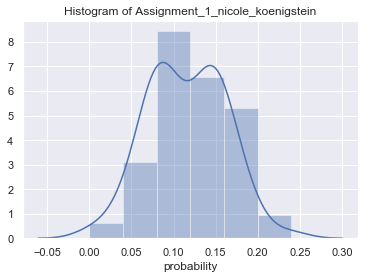

In [180]:
import matplotlib.pyplot as plt
sns.set();
sns.distplot(myscores,bins=6,hist=True,kde = True)
plt.xlabel("probability")
plt.title('Histogram of Assignment_1_nicole_koenigstein')

Text(0.5, 0, 'probability')

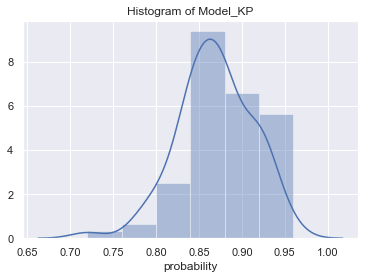

In [181]:
plt.title('Histogram of Model_KP')
sns.distplot(theirscores,bins=6,hist=True,kde=True)
plt.xlabel("probability")

In [151]:
ttest,pval = stats.ttest_rel(theirscores, myscores)
print(pval)

1.3239533278193096e-84


## Hypothesis Test Conclusion 

In [152]:
if pval<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

reject null hypothesis


In [163]:
ztest ,pval = stests.ztest(theirscores, x2=myscores, value=0, alternative='two-sided')
print(float(pval))

0.0


In [166]:
# Degrees of Freedom (Two Samples): (N1 + N2) – 2.
df = 2 * size_sample - 2
print(df)

98


In [154]:
normality = {'mypvalue':0,'theirpvalue':0}

sign_level = 0.05 # significance level
# test if populations are normally distributed
print('Testing normality of my scores...')
value, normality['mypvalue'] = normaltest(myscores)
if normality['mypvalue'] >= sign_level:
    print('It is likely that my scores are normal')
else:
    print('It is unlikely that my scores are normal')

print('Testing normality of  their scores...')
value, normality['theirpvalue'] = normaltest(theirscores)
if normality['theirpvalue'] >= sign_level:
	print('It is likely that their scores are normal')
else:
	print('It is unlikely that their scores are normal')

Testing normality of my scores...
It is likely that my scores are normal
Testing normality of  their scores...
It is likely that their scores are normal


In [167]:
# Apply t-test if scores are normally distributed
if normality['mypvalue']>=sign_level and normality['theirpvalue']>=sign_level :
    print('Scores are normally distributed. Applying Student t-test...')
    value, pvalue = stats.ttest_ind(myscores, theirscores, equal_var=False)
    
else: # use Kolmogorov-Smirnov test for non-Gaussian distribution
    print('Scores are not normally distributed. Applying Kolmogorov-Smirnov test ...')
    value, pvalue = ks_2samp(myscores, theirscores)
    
# Check p-value at significance level to reject or to aceept null hypothesis(they are the same distribution)
if pvalue > sign_level:
    print(f'Failed to reject null hypothesis (H0). We cannot reject the hypothesis that the distributions of the two samples are the same at {sign_level:.2f}%.')
else:
    print(f'Reject null hypothesis (H0). The two scores are significantly different at {sign_level*100:.2f}%.')

Scores are normally distributed. Applying Student t-test...
Reject null hypothesis (H0). The two scores are significantly different at 5.00%.


As shown in the above output from the test, the two models (Assignment_1_nicole_koenigstein and Model_KP) are <b>significantly different</b>. 

### Sources:
https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.1%3A_Comparison_of_Two_Population_Means%3A_Large%2C_Independent_Samples

https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce

https://stattrek.com/hypothesis-test/paired-means.aspx

https://en.wikipedia.org/wiki/Student%27s_t-test

http://numoraclerecipes.blogspot.com/2007/12/students-t-distribution-degrees-of.html